https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data

In [63]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [64]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [65]:
pd.set_option('display.max_colwidth',None)

In [66]:
df = pd.read_csv('Training_set.csv')
df_test = pd.read_csv('Testing_set.csv')

In [67]:
df['filename'] = "C:/Users/danie/OneDrive/Desktop/Data_science/ML/Butterfly Image Classification/train/" +df['filename']
df_test['filename'] = "C:/Users/danie/OneDrive/Desktop/Data_science/ML/Butterfly Image Classification/test/" +df_test['filename']

In [68]:
train = df
val = train.sample(frac=.2)
train = train.drop(val.index)
test = df_test

In [69]:
label_encoder = LabelEncoder()

label_encoder.fit(df['label'])

#params for ResNet18
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=.2,contrast=.2,saturation=.2),
    transforms.ToTensor(),
    transforms.Normalize([.485,.456,.406],[.229,.224,.225])
])

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([.485,.456,.406],[.229,.224,.225])
])

In [133]:
class CustomImageDataset(Dataset):
    def __init__(self,df,transforms=None,has_label=True):
        super().__init__()
        self.df = df
        self.has_label= has_label
        self.transforms = transforms
        
        
        if self.has_label:
            self.labels = torch.tensor(label_encoder.transform(df['label']),dtype=torch.long)

        
    def __len__(self):
        return self.df.shape[0]
        #return len(self.df) same shit
        
    def __getitem__(self,idx):
        image_path = self.df.filename.iloc[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)
            
        if self.has_label:
            label = self.labels[idx]
            return image,label
        else:
            return image,str(image_path)

        
    

In [134]:
train_dataset = CustomImageDataset(df=train,transforms=transform_train)
val_dataset = CustomImageDataset(df=val,transforms=transform)
test_dataset = CustomImageDataset(df=test,transforms=transform,has_label=False)

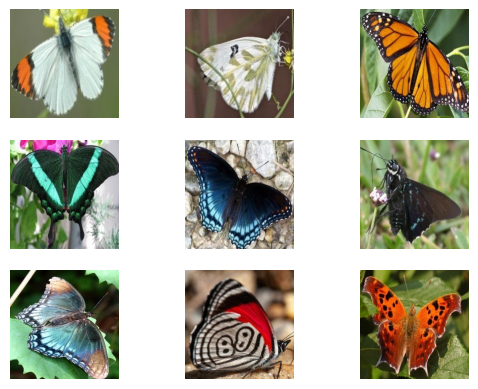

In [72]:
n_rows =3 
n_cols =3
f,axs = plt.subplots(n_rows,n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image=Image.open(df.sample(1)['filename'].iloc[0]).convert('RGB')
        axs[row,col].imshow(image)
        axs[row,col].axis('off')

In [73]:
LR = 3e-4
BATCH_SIZE=48
EPOCHS=15

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_loader =DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features,256),
    nn.ReLU(),
    nn.Dropout(.3),
    nn.Linear(256,df.label.nunique())
)

model = model.to(device)

In [76]:
from torchsummary import summary
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda x:x.requires_grad,model.parameters()),lr=LR)

In [78]:
total_train_loss_plot = []
total_train_acc_plot = []
total_validation_acc_plot=[]
total_validation_loss_plot=[]

In [79]:
best_val_acc=0

for epoch in range(EPOCHS):
    total_train_acc = 0
    total_train_loss = 0
    model.train()
    
    for inputs ,labels in tqdm(train_loader,desc='Training...',leave=False):
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        train_loss = criterion(outputs,labels)
        
        train_loss.backward()
        optimizer.step()
        
        total_train_loss += train_loss.item() * inputs.size(0)
        train_acc =  (torch.argmax(outputs,axis=1)==labels).sum().item()
        total_train_acc += train_acc
        
    avg_train_loss = total_train_loss / len(train_dataset)
    avg_train_acc = total_train_acc / len(train_dataset)
        
    model.eval()
    total_val_acc = 0
    total_val_loss=0
    with torch.no_grad():
        for inputs,labels in val_loader:
            inputs,labels = inputs.to(device),labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs,labels)
            
            total_val_loss += val_loss.item() * inputs.size(0)
            val_acc = (torch.argmax(outputs,axis=1)==labels).sum().item()
            total_val_acc += val_acc
    
    avg_val_loss = total_val_loss/len(val_dataset)
    avg_val_acc = total_val_acc/len(val_dataset)
    
    total_train_loss_plot.append(round(avg_train_loss,2))
    total_validation_loss_plot.append(round(avg_val_loss,2))
    
    total_train_acc_plot.append(round(avg_train_acc*100,2))
    total_validation_acc_plot.append(round(avg_val_acc*100,2))

    print(f'Epoch:{epoch+1}/{EPOCHS},Train Loss:{total_train_loss_plot[epoch]}, Train Acc:{total_train_acc_plot[epoch]}%')
    print(f'Epoch:{epoch+1}/{EPOCHS}, Val Loss:{total_validation_loss_plot[epoch]}, Val Acc:{total_validation_acc_plot[epoch]}%')
    
    if avg_val_acc> best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(),'best_model_butteryfly.pth')
        print(f'Model saved with val acc:{round(avg_val_acc*100,2)}%')
    

Epoch:1/15,Train Loss:4.03, Train Acc:11.79%
Epoch:1/15, Val Loss:3.66, Val Acc:33.0%
Model saved with val acc:33.0%


Epoch:2/15,Train Loss:3.03, Train Acc:39.08%
Epoch:2/15, Val Loss:2.7, Val Acc:56.23%
Model saved with val acc:56.23%


Epoch:3/15,Train Loss:2.14, Train Acc:55.91%
Epoch:3/15, Val Loss:1.99, Val Acc:67.31%
Model saved with val acc:67.31%


Epoch:4/15,Train Loss:1.61, Train Acc:65.13%
Epoch:4/15, Val Loss:1.57, Val Acc:73.15%
Model saved with val acc:73.15%


Epoch:5/15,Train Loss:1.31, Train Acc:70.24%
Epoch:5/15, Val Loss:1.32, Val Acc:75.46%
Model saved with val acc:75.46%


Epoch:6/15,Train Loss:1.11, Train Acc:73.55%
Epoch:6/15, Val Loss:1.17, Val Acc:77.38%
Model saved with val acc:77.38%


Epoch:7/15,Train Loss:0.98, Train Acc:75.46%
Epoch:7/15, Val Loss:1.05, Val Acc:77.23%


Epoch:8/15,Train Loss:0.9, Train Acc:77.23%
Epoch:8/15, Val Loss:0.98, Val Acc:79.92%
Model saved with val acc:79.92%


Epoch:9/15,Train Loss:0.82, Train Acc:79.0%
Epoch:9/15, Val Loss:0.91, Val Acc:79.92%


Epoch:10/15,Train Loss:0.77, Train Acc:79.53%
Epoch:10/15, Val Loss:0.86, Val Acc:82.08%
Model saved with val acc:82.08%


Epoch:11/15,Train Loss:0.71, Train Acc:81.13%
Epoch:11/15, Val Loss:0.81, Val Acc:82.0%


Epoch:12/15,Train Loss:0.68, Train Acc:81.27%
Epoch:12/15, Val Loss:0.76, Val Acc:83.31%
Model saved with val acc:83.31%


Epoch:13/15,Train Loss:0.65, Train Acc:82.27%
Epoch:13/15, Val Loss:0.77, Val Acc:81.62%


Epoch:14/15,Train Loss:0.62, Train Acc:83.04%
Epoch:14/15, Val Loss:0.73, Val Acc:82.85%


Epoch:15/15,Train Loss:0.59, Train Acc:83.73%
Epoch:15/15, Val Loss:0.7, Val Acc:83.15%


In [142]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, df.label.nunique())
)

model.load_state_dict(torch.load('best_model_butteryfly.pth',map_location=device,weights_only=True))
model = model.to(device)


In [145]:
model.eval()
predictions = []

with torch.no_grad():
    for images,filename in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs,axis=1)
        for fname,pred in zip(filename,preds):
            name = os.path.basename(fname)
            predictions.append((name,pred.item()))        

In [146]:
predictions

[('Image_21.jpg', 15),
 ('Image_1920.jpg', 59),
 ('Image_1710.jpg', 14),
 ('Image_2379.jpg', 41),
 ('Image_1337.jpg', 8),
 ('Image_2317.jpg', 41),
 ('Image_976.jpg', 34),
 ('Image_774.jpg', 52),
 ('Image_2437.jpg', 65),
 ('Image_1583.jpg', 43),
 ('Image_2135.jpg', 16),
 ('Image_1964.jpg', 24),
 ('Image_990.jpg', 7),
 ('Image_702.jpg', 33),
 ('Image_2179.jpg', 26),
 ('Image_2605.jpg', 0),
 ('Image_881.jpg', 56),
 ('Image_2677.jpg', 12),
 ('Image_122.jpg', 33),
 ('Image_1496.jpg', 23),
 ('Image_2628.jpg', 21),
 ('Image_1737.jpg', 63),
 ('Image_2299.jpg', 48),
 ('Image_1334.jpg', 58),
 ('Image_382.jpg', 73),
 ('Image_2644.jpg', 26),
 ('Image_1350.jpg', 36),
 ('Image_913.jpg', 28),
 ('Image_2526.jpg', 11),
 ('Image_2309.jpg', 17),
 ('Image_2542.jpg', 19),
 ('Image_782.jpg', 16),
 ('Image_808.jpg', 28),
 ('Image_2713.jpg', 29),
 ('Image_2198.jpg', 52),
 ('Image_1434.jpg', 68),
 ('Image_190.jpg', 42),
 ('Image_2042.jpg', 66),
 ('Image_1803.jpg', 28),
 ('Image_2194.jpg', 13),
 ('Image_65.jpg'